# Beacon Time Series, across the transition

Edit selector= below

Look at the beacons with the largest normalized spread.

( Steal plotMultiBeacons() from here.)

In [1]:
import math
import numpy as np
import pandas as pd
import BQhelper as bq

%matplotlib nbagg
import matplotlib.pyplot as plt

bq.project = "mlab-sandbox"
# bq.dataset = 'mattmathis'
# bq.UnitTestRunQuery()
# bq.UnitTestWriteQuery()
UnitTest=False

In [2]:
# Plot simple timeseries for a list of beacons
# UnitTest=True

query="""
SELECT
  a.TestTime,
  client.IP,
  a.MeanThroughputMbps,
  node._instruments
# FROM   `mlab-sandbox.mm_unified_testing.unified_{selector}`
FROM `measurement-lab.ndt.unified_{selector}`
WHERE client.IP in ( {clientIP} )
AND test_date > '2019-03-01'
ORDER BY TestTime

"""
global StashData

 
def plotMultiBeacons(clients, columns=1, width=10, data=None, selector='downloads'):
    if data is None:
        clist = '"'+'", "'.join(clients)+'"'
        data=bq.QueryTimestampTimeseries(query, clientIP=clist, selector=selector)
        global StashData # Skip slow queries when debugging
        StashData = data
    rows = math.ceil(len(clients) / float(columns))
    figLen = width/float(columns)*rows  # assume square subplots
    print('Size', figLen, width)
    plt.rcParams['figure.figsize'] = [ width, figLen]
    
    fig, axs = plt.subplots(nrows=rows, ncols=columns, squeeze=False, sharex='all')
    for ax, client in zip([i for j in axs for i in j], clients):
        print ('Beacon: '+client)
        ax.set_title('Beacon: '+client)
        cdata = data[data['IP'] == client]
        ax.plot(cdata['MeanThroughputMbps'][cdata["_instruments"] == 'web100'], 'b.',
            cdata['MeanThroughputMbps'][cdata["_instruments"] == 'tcpinfo'], 'r.')
    fig.autofmt_xdate()
    fig.show()

if UnitTest:
    # %matplotlib nbagg

    try:
        TestData = StashData
        print('Using StashData')
    except:
        pass

    try:
        TestData
    except:
        print('Genereating test data')
        clients = [
            '69.68.23.44', # Max deltaMean
            '96.229.66.58', # Max deltaMax
            '73.210.92.196',
        ]
        
        clist = '"'+'", "'.join(clients)+'"'
        TestData=bq.QueryTimestampTimeseries(query, clientIP=clist, selector='downloads')
    # plt.ion()
    clients=list(TestData['IP'].unique())
    print (clients)
    plotMultiBeacons(clients, data=TestData, columns=2, width=10)
    print ('Done')


In [3]:
if UnitTest: # Don't go on to the main event
    import time
    time.sleep(5) # Make sure the asyncronous ploting finishes in the background
    STOP # die

In [4]:
listQ='''
# Find clients with ~40 low varience weeks since 2019-01-01
# High varience weeks (e.g. step discontinuities) are ignored

WITH

rawStats AS (
  SELECT
    client.IP,
    EXTRACT(WEEK FROM test_date) AS week,
    STDDEV( a.MeanThroughputMbps ) AS dev,
    AVG( a.MeanThroughputMbps ) AS meanTput,
    count (*) AS tests
  FROM
    `measurement-lab.ndt.unified_{selector}`
  WHERE
    test_date > '2019-01-01'
  GROUP BY
    IP, week
  HAVING 
    tests > 12 AND meanTput > 0
),

selectBest AS (
  SELECT 
    IP,
    count (*) AS weeks,
    APPROX_QUANTILES(dev / meanTput, 100)[OFFSET(90)] as dev90,
    AVG(meanTput) AS meanTput
  FROM
    rawStats 
  GROUP BY
    IP
  HAVING weeks > 50
  ORDER BY dev90
)


SELECT * FROM selectBest LIMIT 10
'''

Size 25.0 10


<IPython.core.display.Javascript object>


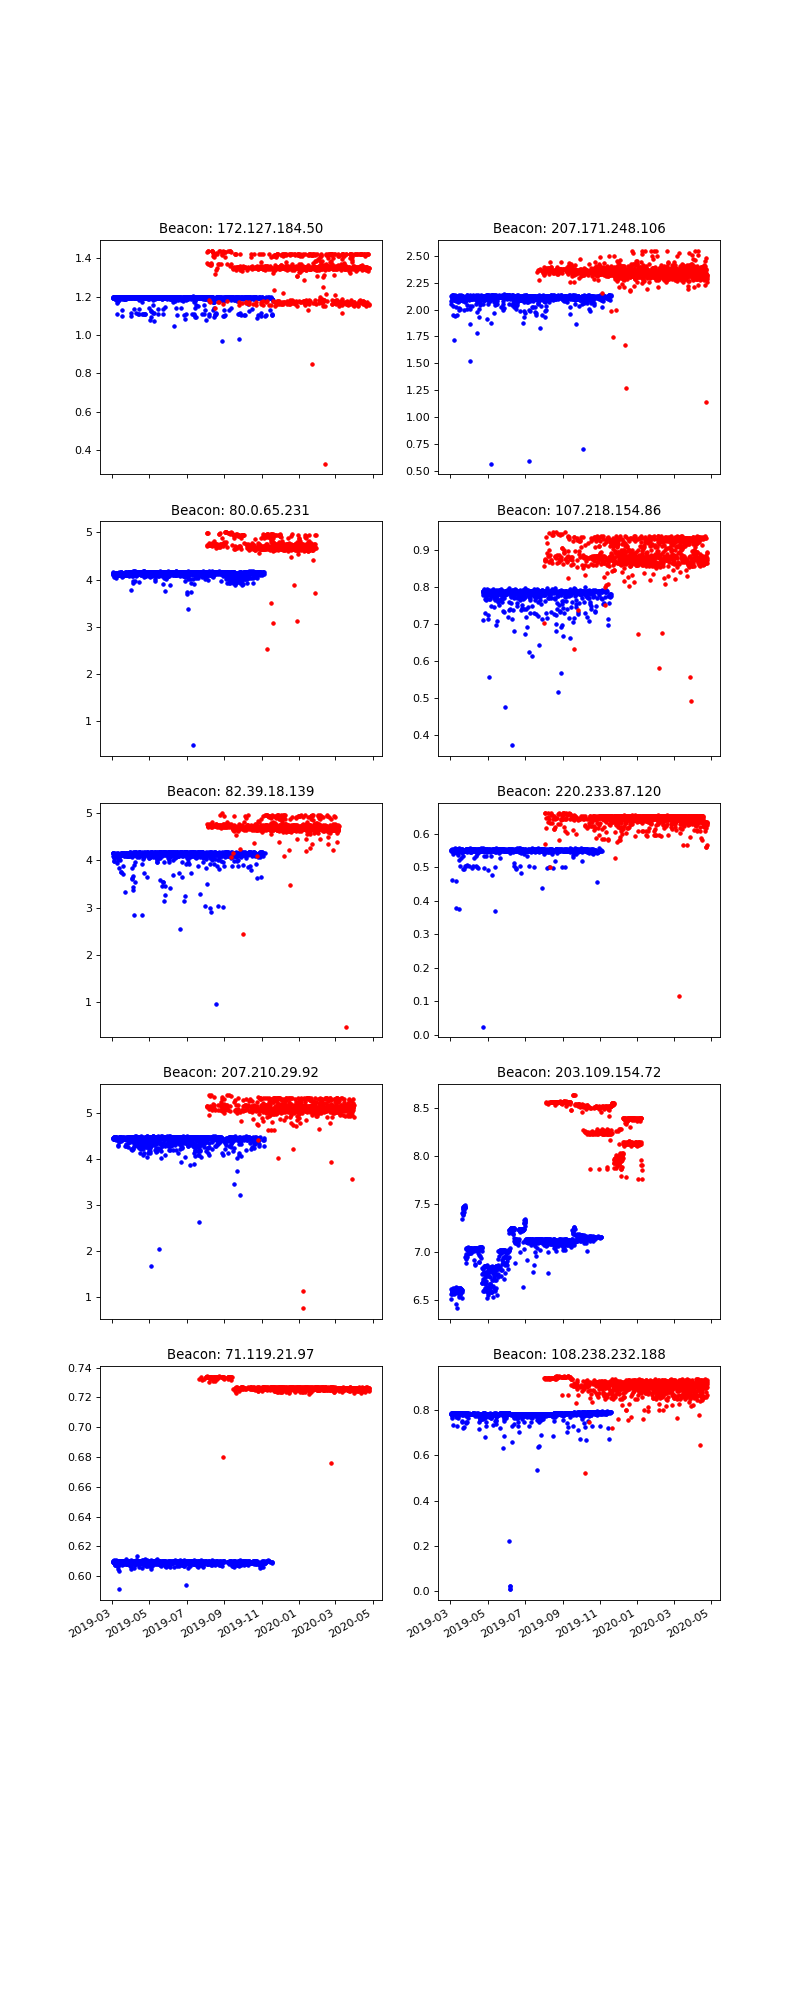

Beacon: 172.127.184.50
Beacon: 207.171.248.106
Beacon: 80.0.65.231
Beacon: 107.218.154.86
Beacon: 82.39.18.139
Beacon: 220.233.87.120
Beacon: 207.210.29.92
Beacon: 203.109.154.72
Beacon: 71.119.21.97
Beacon: 108.238.232.188


In [5]:
%matplotlib nbagg

selector="downloads"
selector="uploads"
stepbeacons=bq.QueryDataFrame(listQ, selector=selector)
plotMultiBeacons(stepbeacons['IP'], 2, width=10, selector=selector)

In [6]:
UnitTest=True  # Rerunning is always testing

Size 6.0 6


<IPython.core.display.Javascript object>


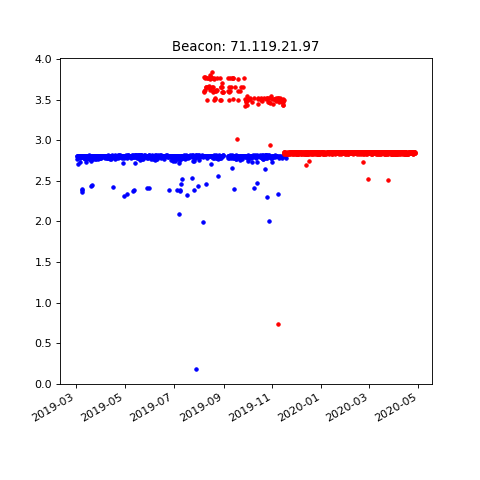

Beacon: 71.119.21.97


In [8]:
clients=['71.119.21.97']
plotMultiBeacons(clients, columns=1, width=6)